# Statistics Introduction Exercises

A few basic exercises mostly taken from [here](https://mdonega.github.io/hep-datanalysis-jb/preface.html).

## Probability and Probability Distributions

1. For each of the following rates (0.1, 0.5, 1, 5) generate 10k events from a Poisson distribution and plot it

In [2]:
import numpy as np
import matplotlib.pyplot as plt

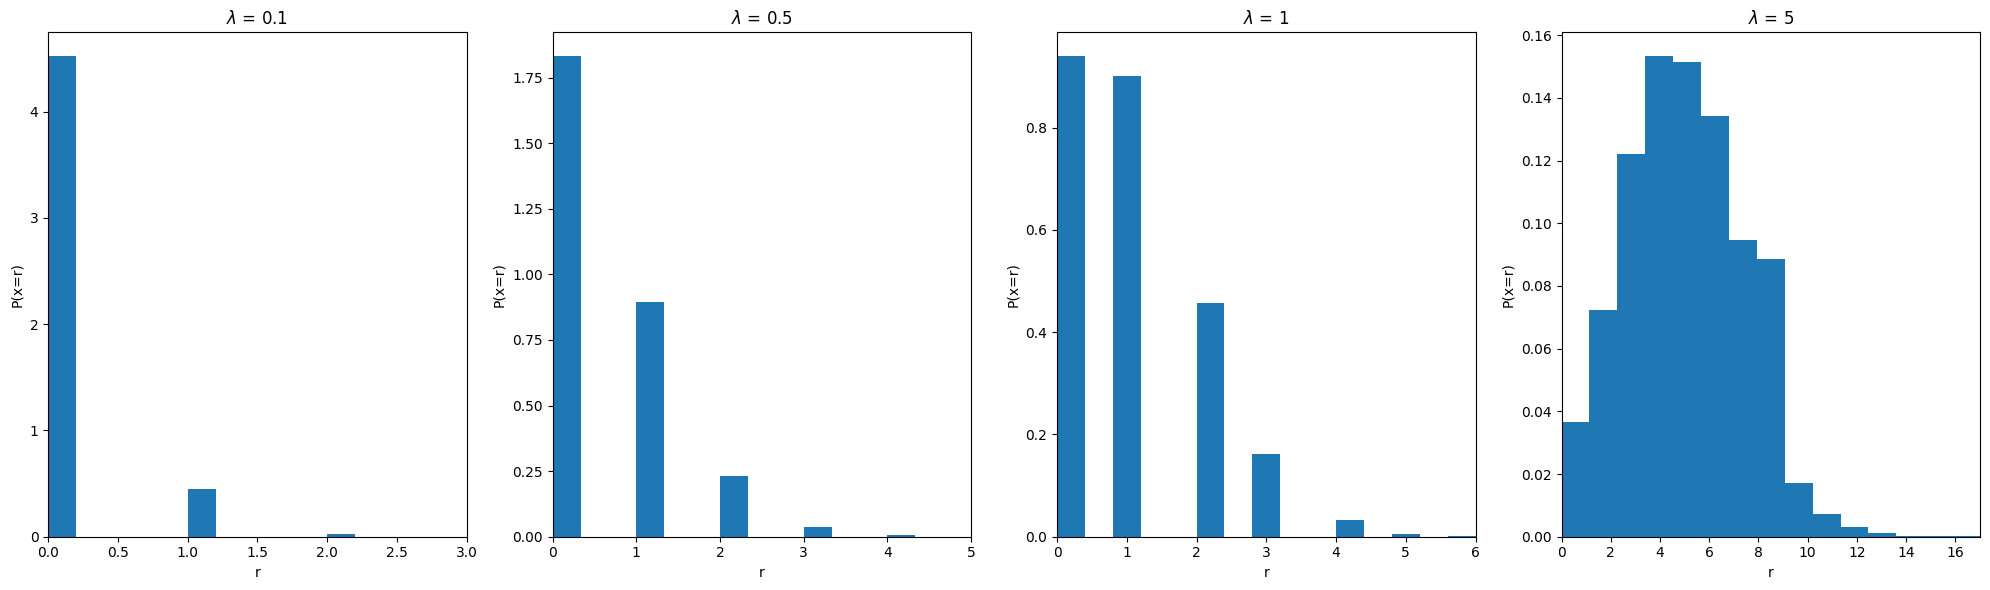

In [3]:
l = [0.1, 0.5, 1, 5]
repetitions = 10000

fig, ax = plt.subplots(1, len(l), figsize=(20, 6))
for i, l_ in enumerate(l):
    samples = np.random.poisson(l_, repetitions)
    ax[i].hist(samples, bins=15, density=True)
    ax[i].set_xlim(0, np.max(samples))
    ax[i].set_title(f"$\lambda$ = {l_}")
    ax[i].set_xlabel("r")
    ax[i].set_ylabel(r"P(x=r)")
plt.tight_layout();

2. Draw PDF and CDF (for arbitrary values of their parameters) for the following distributions:

2. a. gaussian

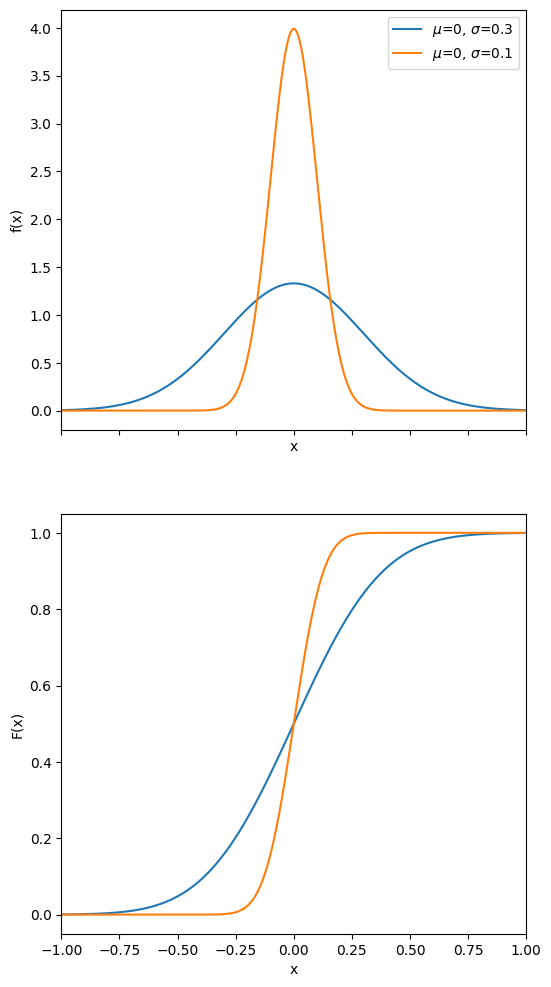

In [4]:
from scipy.stats import norm

params = [(0, 0.3), (0, 0.1)]
size = 10000
limits = (-1, 1)

fig, (axf, axF) = plt.subplots(2, 1, figsize=(6,12), sharex=True)
for musigma in params:
    mu, sigma = musigma
    frozen = norm(mu, sigma)
    x = np.linspace(*limits, size)
    fx = frozen.pdf(x)
    Fx = frozen.cdf(x)
    axf.plot(x, fx, linestyle="-", label=f"$\mu$={mu}, $\sigma$={sigma}")
    axF.plot(x, Fx, linestyle="-", label=f"$\mu$={mu}, $\sigma$={sigma}")
    axf.legend()
    axf.set_xlabel("x")
    axF.set_xlabel("x")
    axf.set_ylabel("f(x)")
    axF.set_ylabel("F(x)")
    axf.set_xlim(*limits)
    axF.set_xlim(*limits)

2. b. $\chi^2$

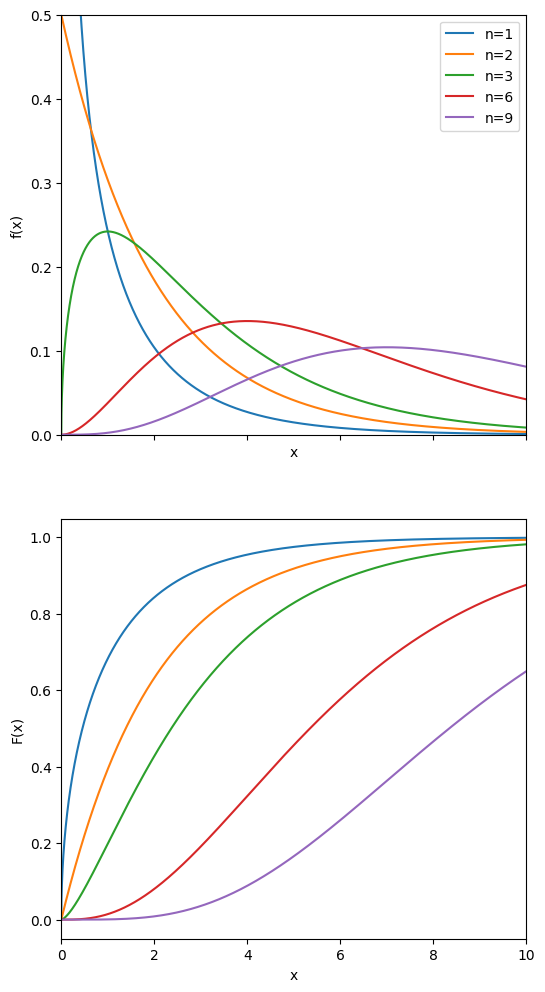

In [5]:
from scipy.stats import chi2

dofs = [1, 2, 3, 6, 9]
size = 10000
limits = (0, 10)

fig, (axf, axF) = plt.subplots(2, 1, figsize=(6,12), sharex=True)
for dof in dofs:
    frozen = chi2(dof)
    x = np.linspace(*limits, size)
    fx = frozen.pdf(x)
    Fx = frozen.cdf(x)
    axf.plot(x, fx, linestyle="-", label=f"n={dof}")
    axF.plot(x, Fx, linestyle="-", label=f"n={dof}")
    axf.legend()
    axf.set_xlabel("x")
    axF.set_xlabel("x")
    axf.set_ylabel("f(x)")
    axF.set_ylabel("F(x)")
    axf.set_xlim(*limits)
    axF.set_xlim(*limits)
    axf.set_ylim(0, 0.5)

2. c. Log-normal

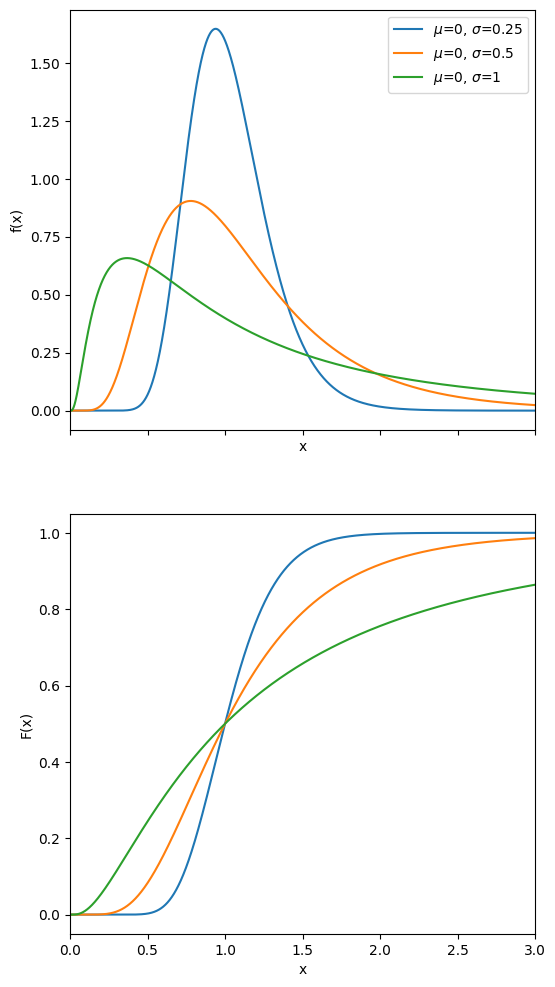

In [6]:
from scipy.stats import lognorm

params = [(0, 0.25), (0, 0.5), (0, 1)]
size = 10000
limits = (0, 3)

fig, (axf, axF) = plt.subplots(2, 1, figsize=(6,12), sharex=True)
for musigma in params:
    mu, sigma = musigma
    frozen = lognorm(s=sigma, scale=np.exp(mu))
    x = np.linspace(*limits, size)
    fx = frozen.pdf(x)
    Fx = frozen.cdf(x)
    axf.plot(x, fx, linestyle="-", label=f"$\mu$={mu}, $\sigma$={sigma}")
    axF.plot(x, Fx, linestyle="-", label=f"$\mu$={mu}, $\sigma$={sigma}")
    axf.legend()
    axf.set_xlabel("x")
    axF.set_xlabel("x")
    axf.set_ylabel("f(x)")
    axF.set_ylabel("F(x)")
    axf.set_xlim(*limits)
    axF.set_xlim(*limits)

3. Visually demonstrate an application of the Central Limit Theorem (CLT): the distribution of the sum of multiple independent uniform random variables tends to a gaussian as more variables are added.

In [ ]:
evts = 100000
limits = (-2, 2)
Ns = list(range(1, 5))

sample = np.random.uniform(*limits, (evts, len(Ns)))

fig, ax = plt.subplots(1, len(Ns), figsize=(20, 6))
for i, N in enumerate(Ns):
    mean = np.sum(sample[:, :N], axis=-1)
    ax[i].hist(mean, bins=50, range=(-10,10), label=N, density=False)
    ax[i].set_title(f"N={N}")
    ax[i].set_xlabel("x")
    ax[i].set_ylabel("Number of Events")

plt.tight_layout()

## Likelihood

Generate 10k events from a gaussian pdf with $\mu = 3$ and $\sigma = 2.3$.
Then, define a negative log-likelihood (NLL) and apply the maximum likelihood method (NLL minimization) to find the values $\hat{\mu}$ and $\hat{\sigma}$ that maximize the likelihood (minimize the NLL). These values are estimators of $\mu$ and $\sigma$.
Assign an uncertainty to the estimators using the inverse of the hessian around the minimum and the graphic method (values of $\hat{\theta}$ for which $\ln L$ decreases by 0.5).
In the graphic method case, reduce the free parameters to only one ($\mu$) by setting $\sigma$ to its true value.

**Hint**: in the first case, you can minimize the NLL using [scipy.optimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) and access the inverse of the Hessian using the `hess_inv` method of the result returned.

In [7]:
import numpy as np
from scipy.optimize import minimize
from dataclasses import dataclass

@dataclass
class Likelihood:
    function: callable
    data: np.ndarray

    def __call__(self, *params):
        return np.prod(self.function(self.data, *params))


class NLL(Likelihood):
    def __call__(self, *params):
        return -np.sum([np.log(self.function(self.data, *params))])

def gaussian(x, mu, sigma):
    return (
        1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))
    )

mu_true = 3.0
sigma_true = 2.3

np.random.seed(42)  # for reproducibility
data = np.random.normal(mu_true, sigma_true, size=10_000)

nll = NLL(function=gaussian, data=data)

initial_guess = [2.0, 1.0]
result = minimize(lambda params: nll(*params), x0=initial_guess, method='L-BFGS-B', bounds=[(None, None), (1e-6, None)])

if result.success:
    mu_hat, sigma_hat = result.x
    cov_matrix = result.hess_inv.todense()
    mu_hat_unc, sigma_hat_unc = np.sqrt(np.diag(cov_matrix))
    print(f"Estimated mu: {mu_hat:.4f} +/- {mu_hat_unc:.4f}")
    print(f"Estimated sigma: {sigma_hat:.4f} +/- {sigma_hat_unc:.4f}")

Estimated mu: 2.9951 +/- 0.1568
Estimated sigma: 2.3078 +/- 0.1077


Estimated mu: 2.9951 +/- 0.0229


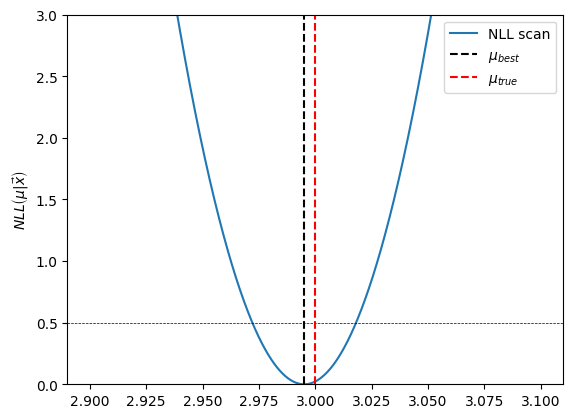

In [8]:
n_mu  = 1000
mus = np.linspace(2.9, 3.1, n_mu)

nll_scan = np.array([nll(mu, sigma_true) for mu in mus])    
idx_min_nll_scan = np.argmin(nll_scan)
mu_best = mus[idx_min_nll_scan]
nll_scan -= nll_scan[idx_min_nll_scan] # move minimum to 0
arr_min_nll_ = np.ones(n_mu)*0.5
low_idx, high_idx = np.argwhere(np.diff(np.sign(nll_scan - arr_min_nll_))).flatten()
unc = np.abs(mus[high_idx] - mus[low_idx])
mu_low = abs(mu_best - mus[low_idx])
mu_high = abs(mu_best - mus[high_idx])

print(f"Estimated mu: {mu_best:.4f} +/- {unc/2:.4f}")

fig, ax = plt.subplots()
nll_label = r"$NLL\left(\mu | \vec{x}\right)$"
ax.plot(mus, nll_scan, label="NLL scan")
ax.set_ylim(0, 3)
ax.set_ylabel(nll_label)
ax.axhline(0.5, color="k", linestyle="--", linewidth=0.5)
ax.axvline(mu_best, color="k", linestyle="--", label=r"$\mu_{best}$")
ax.axvline(mu_true, color="r", linestyle="--", label=r"$\mu_{true}$")
ax.legend();

## Hypothesis Testing

### Average Body Temperature

Consider a population of many adults. A researcher hypothesized that the average adult body temperature is lower than the often-advertised 37 $^\circ$. That is, the researcher wants an answer to the question: "Is the average adult body temperature really 37 $^\circ$? Or is it lower?".

In order to answer the question, he selects a random sample of 100 adults. The average body temperature of the sampled adults is 36.7 degrees, with a standard deviation of 1.4.

#### Part 1

What can the reasearcher say about his initial hypothesis?

In order to answer, use the following hints and answer these questions:

- the test statistic you can use is $t = \frac{\bar{x} - \mu}{s/\sqrt{n}}$ (where $\bar{x}$ is the mean of the sample, $\mu$ is the population mean, $s$ is the standard deviation of the sample and $n$ is the size of the sample), whose PDF is a t-student with $n - 1$ degrees of freedom
- what is the null hypothesis? and the alternative?
- can the researcher reject the null hypothesis with a significance level of 0.05? and 0.01?

#### Solution

This is the simplest case of hypothesis test, in which we want to use the data that we collected to make a statement about a certain model that is supposed to be the true one (i.e. the **null hypothesis**). To do this we need some ingredients:

- test statistic (a function of the data), given above;
- the PDF followed by the test statistic in case the null hypothesis is valid; one can have the analytical form (part 1) or sample it (part 2);
- a significance level (**decided by us!**) at which we want to exclude the null hypothesis (0.05 and 0.01 in our case).

Using the test statistic applied to the data we gathered and the PDF of the test statistic for the null hypothesis we can compute the **p-value** of our data, defined as the probability (under null hypothesis) of obtaining a result equal to or more extreme than what was actually observed. If the p-value is lower than the significance level we chose, we can say that we can **exclude** the null hypothesis at that significance level.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, t
from scipy.integrate import quad

In [10]:
mu_null = 37

n_sample = 100
mu_sample = 36.7
std_sample = 1.4

In [11]:
def test_statistic(x, mu, s, n):
    return (x - mu) / (s / np.sqrt(n))

In [12]:
observed_ts = test_statistic(mu_sample, mu_null, std_sample, n_sample)
print(f"t_obs = {observed_ts}")

t_obs = -2.142857142857123


In [13]:
# check multiple values of TS to see in which direction we have "more extreme results"
test_temp = np.array([40, 39, 37, 36.5, 35, 31])
print(test_statistic(test_temp, mu_null, std_sample, n_sample))

[ 21.42857143  14.28571429   0.          -3.57142857 -14.28571429
 -42.85714286]


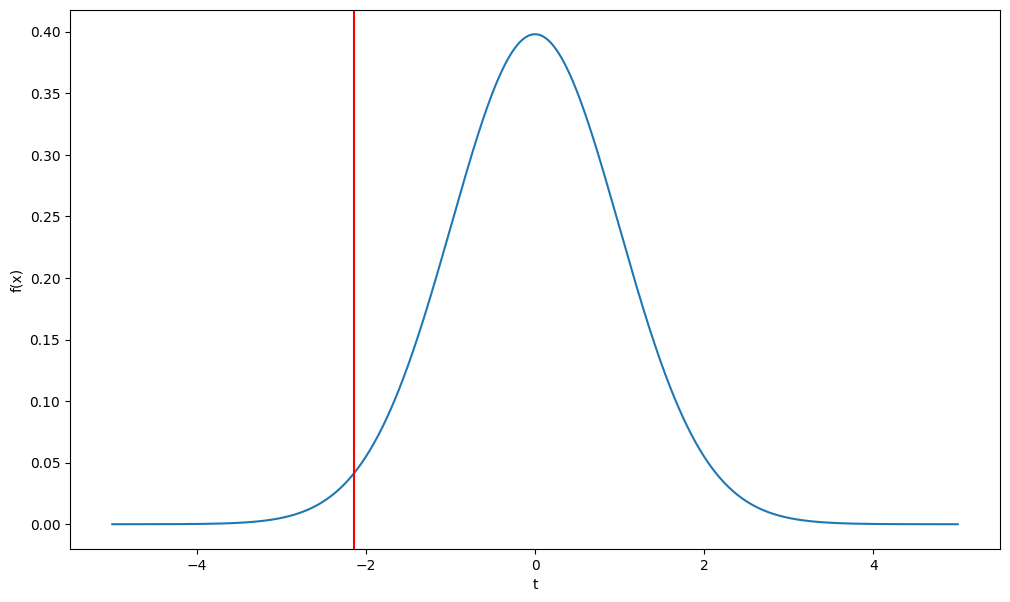

In [14]:
frozen = t(n_sample - 1)
x = np.linspace(-5, 5, 1000)
y = frozen.pdf(x)

fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(x, y)
ax.axvline(observed_ts, color="red")
ax.set_xlabel("t")
ax.set_ylabel("f(x)");

In [15]:
p_value, _ = quad(frozen.pdf, -np.inf, observed_ts)
print(f"p-value = {p_value}")

p-value = 0.017287890141442858


Can the null hypothesys be rejected with a significance level of 5% (CL of 95%)?

In [16]:
p_value < 0.05

True

Can the null hypothesys be rejected with a significance level of 1% (CL of 99%)?

In [17]:
p_value < 0.01

False

#### Part 2

Repeat the exercise, but instead of using the t-student PDF sample the distribution from what you know about the null hypothesis. You can consider the temperature of the population following a gaussian distribution with mean 37 (as stated above) and standard deviation 0.4 (one of the values found in medical literature).

#### Solution

In order to sample the distribution followed by the test statistic in case of null hypothesis, we need to throw a (possibly large) number of **toy experiments** and use the test statistic computed on each of them to *fill a histogram*. That histogram will be the sampled PDF that we are looking for.

How can each toy experiment be simulated? The answer is in the question: sample a number ```toy_size``` of events (people, in this case) which is **equal to the data sample aquired** from a gaussian distribution with mean 37 and standard deviation 0.4. 

In [18]:
mu_null = 37
sigma_null = 0.4

toy_size = 100
n_toys = 50000

In [19]:
# rows = elements in one toy
# columns = how many toys
samples = np.random.normal(mu_null, sigma_null, size=(toy_size, n_toys))

In [20]:
means = np.mean(samples, axis=0)
stds = np.std(samples, axis=0)

In [21]:
test_statistics = test_statistic(means, mu_null, stds, toy_size)

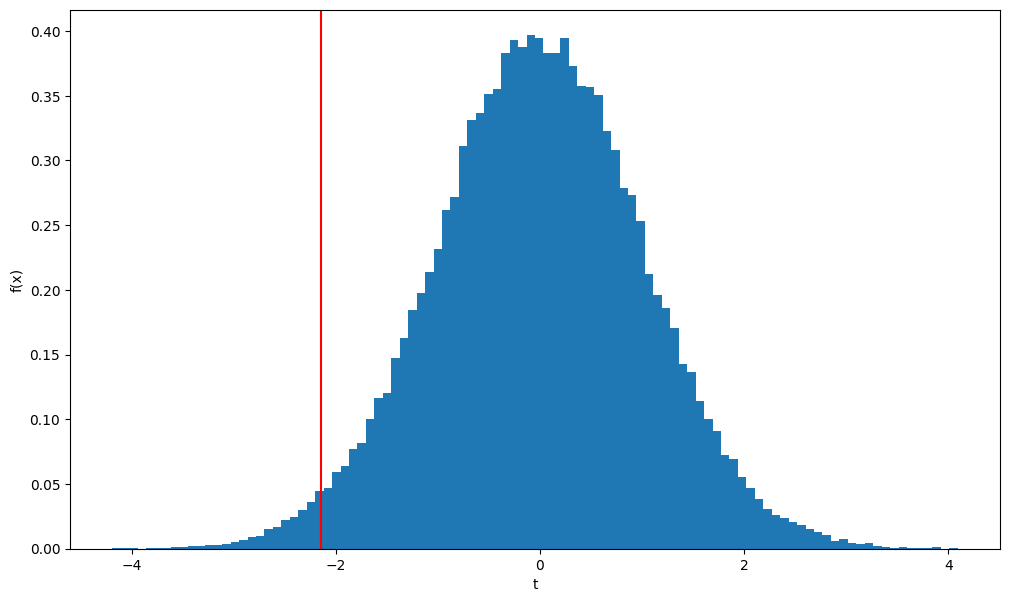

In [22]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.axvline(observed_ts, color="red")
ax.hist(test_statistics, bins=100, range=(min(test_statistics), max(test_statistics)), density=True)
ax.set_xlabel("t")
ax.set_ylabel("f(x)");

In [23]:
p_value = len(test_statistics[test_statistics < observed_ts]) / len(test_statistics)
print(f"p-value = {p_value}")

p-value = 0.01866


As expected, the two methods give very similar result. In general, the first method is of course faster, but we can use it only if the pdf of the test statistics is known. When this does not happen, we need to sample it with the second method.

### Coin

We suspect a coin might be biased towards heads. We thus toss the coin n = 10 times and observe X = 8. 
Based on this experiment, what can we say about the fairness of the coin?
**Hint**: use a binomial to model the pdf.

In [24]:
from scipy.stats import binom

n = 10
x = 8
p_null = 0.5

# Compute the p-value: P(X >= 8) under H0
# This is the survival function: P(X >= x) = sf(x - 1)
p_value = binom.sf(x - 1, n, p_null)

print(f"P-value for testing p > 0.5: {p_value:.4f}")

alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null hypothesis")


P-value for testing p > 0.5: 0.0547
Fail to reject the null hypothesis
